# Social Media Computing Final Assignment Code

sadness = 0, joy = 1, love = 2, anger = 3, fear = 4, surprise = 5

## Data Preprocessing

In [7]:
import pandas as pd
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

data = pd.read_csv("emotion.csv", index_col=0, nrows=4000)

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, return_tokens=False):
    # lowercase
    lowered = text.lower()
    
    # remove punctuation
    no_punct = re.sub(f"[{re.escape(string.punctuation)}]", "", lowered)

    # tokenization
    tokens = word_tokenize(no_punct)

    # remove stopwords
    no_stopwords = [word for word in tokens if word not in stop_words]

    # lemmatization
    lemmatized = [lemmatizer.lemmatize(word) for word in no_stopwords]

    if return_tokens:
        return lemmatized  # for glove
    else:
        return " ".join(lemmatized)  # for tf-idf

tfidf_data = data['text'].apply(preprocess_text)
glove_data = data['text'].apply(lambda x: preprocess_text(x, return_tokens=True))
bert_data = data['text']
y = data['label']


## Feature Engineering

### TF-IDF 

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(tfidf_data)

print(X_tfidf.shape)


(4000, 6302)


### GloVe Word Embeddings

In [10]:
import numpy as np
import gensim.downloader as api

glove = api.load("glove-wiki-gigaword-100")

def get_avg_glove(tokens):
    vectors = [glove[word] for word in tokens if word in glove]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)

glove_vector = glove_data.apply(get_avg_glove)
X_glove = np.vstack(glove_vector.values)

print(X_glove.shape)


(4000, 100)


### BERT Embeddings

In [23]:
from transformers import BertTokenizer, BertModel
import torch
from tqdm.std import tqdm 

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bertemb_model = BertModel.from_pretrained("bert-base-uncased")

bertemb_model.eval()

bert_embeddings = []

for sentence in tqdm(bert_data, desc="Embedding with BERT"):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=128)

    with torch.no_grad():
        outputs = bertemb_model(**inputs)

    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    bert_embeddings.append(cls_embedding)

X_bert = np.vstack(bert_embeddings)

print("BERT embedding matrix shape:", X_bert.shape)

Embedding with BERT: 100%|██████████| 4000/4000 [05:27<00:00, 12.23it/s]

BERT embedding matrix shape: (4000, 768)


## Opinion Mining

In [24]:
import spacy
from collections import Counter

nlp = spacy.load("en_core_web_sm")
data_opinion = data
texts = data['text']

def extract_opinions(text):
    doc = nlp(text)
    opinions = []
    for token in doc:
        if token.pos_ == "ADJ":  # Opinion word (adjective)
            for child in token.children:
                if child.dep_ in ("nsubj", "amod", "attr") and child.pos_ == "NOUN":
                    opinions.append((child.text.lower(), token.text.lower()))
            for parent in token.head.children:
                if parent.dep_ in ("nsubj", "amod", "attr") and parent.pos_ == "NOUN":
                    opinions.append((parent.text.lower(), token.text.lower()))
    return opinions

tqdm.pandas(desc="Extracting opinions")
data_opinion['opinion_pairs'] = texts.progress_apply(extract_opinions)

print("\n📌 Sample extracted opinion pairs:")
print(data_opinion[data_opinion['opinion_pairs'].str.len() > 0][['text', 'opinion_pairs']].head())

flat_opinions = [pair for pairs in data_opinion['opinion_pairs'] for pair in pairs]
target_counter = Counter([target for target, opinion in flat_opinions])
opinion_counter = Counter([opinion for target, opinion in flat_opinions])

Extracting opinions: 100%|██████████| 4000/4000 [00:22<00:00, 177.36it/s]


📌 Sample extracted opinion pairs:
                                                 text          opinion_pairs
6   i would think that whomever would be lucky eno...    [(whomever, lucky)]
13  i feel like a jerk because the library student...  [(language, english)]
24  i would imagine this is just one of the reason...     [(marriage, hard)]
52  i was feeling lousy and wondering if i d be ab...            [(d, able)]
62  i do with family education and one way we feel...   [(education, vital)]


spaCy model 'en_core_web_lg' loaded.

Analyzing 4000 texts for ABSA...
ABSA analysis complete.


C:\Users\GF63\AppData\Local\Temp\ipykernel_33812\3260788879.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[count for _, count in top_aspects_list],


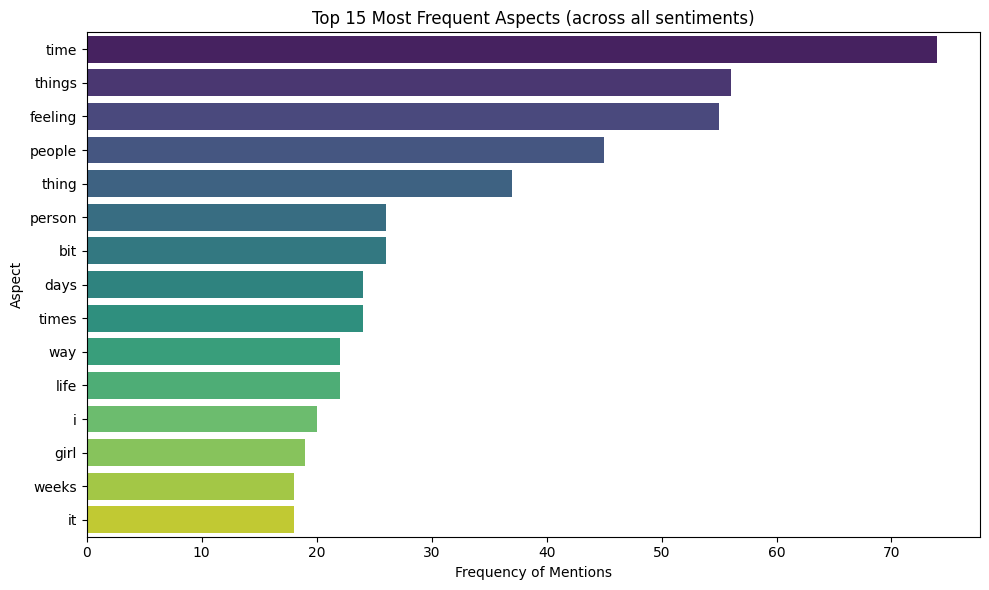

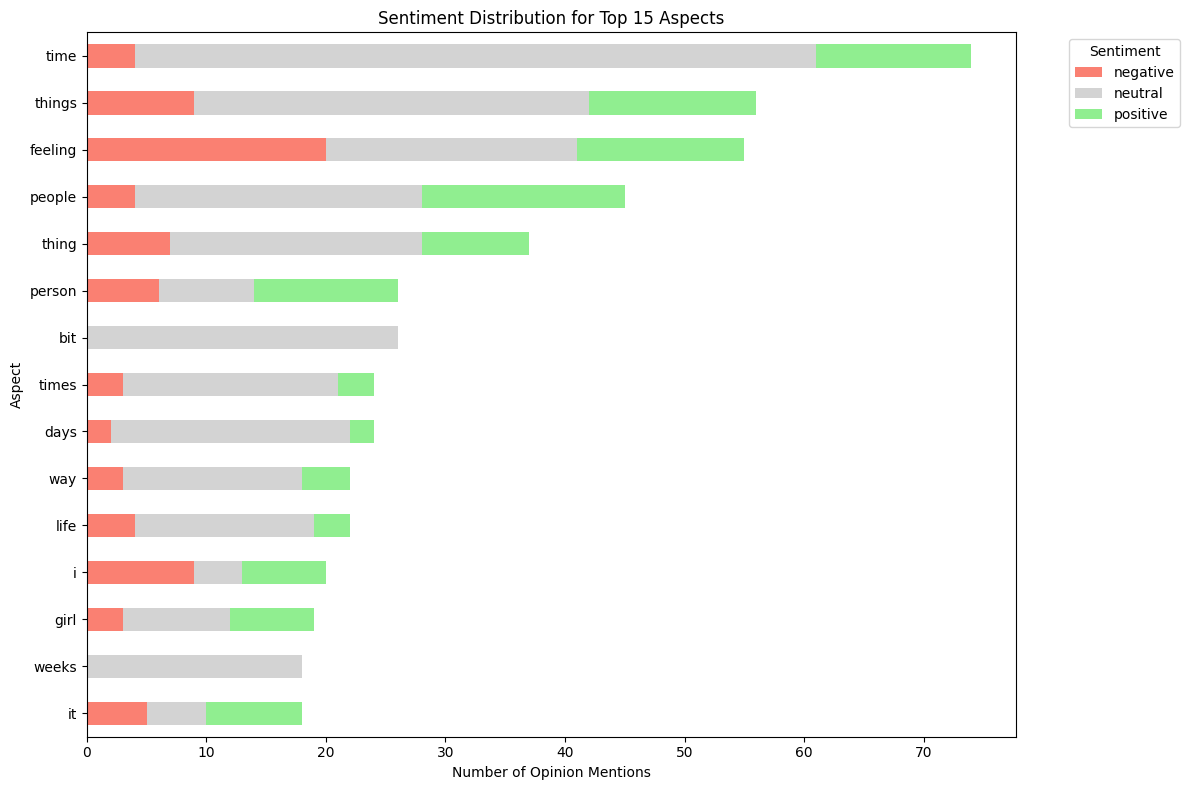


Sample of extracted aspect-opinion-sentiment triples:
        aspect opinion_word  polarity  \
0        weeks         last   neutral   
1        weeks          few   neutral   
2        thing         good  positive   
3  alternative         only   neutral   
4        place     romantic  positive   

                                         source_text  
0  ive enjoyed being able to slouch about relax a...  
1  ive enjoyed being able to slouch about relax a...  
2  ive enjoyed being able to slouch about relax a...  
3  i am a kindergarten teacher and i am thoroughl...  
4  i would think that whomever would be lucky eno...  


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import spacy
from collections import defaultdict, Counter
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except nltk.downloader.DownloadError:
    nltk.download('vader_lexicon')

try:
    nlp = spacy.load("en_core_web_lg")
    print("spaCy model 'en_core_web_lg' loaded.")
except OSError:
    print("spaCy model 'en_core_web_lg' not found. Please run 'python -m spacy download en_core_web_lg' in your terminal.")
    print("Falling back to 'en_core_web_sm' or exiting if not found.")
    try:
        nlp = spacy.load("en_core_web_sm")
        print("Using 'en_core_web_sm' instead.")
    except OSError:
        print("Neither 'en_core_web_lg' nor 'en_core_web_sm' found. Exiting.")
        exit()

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_polarity(text):
    """
    Determines sentiment polarity (positive, negative, neutral) using VADER.
    """
    if not text:
        return "neutral"
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

def perform_absa(texts, nlp_model=nlp):
    """
    Perform Aspect-Based Sentiment Analysis on a list of texts.
    Extracts aspects, their associated opinion words, and the sentiment polarity of those opinion words.

    Returns:
    - aspect_sentiment_data: List of dictionaries, each containing {'aspect', 'opinion_word', 'polarity'}
    - aspect_counts: Counter of aspect frequencies
    """
    aspect_sentiment_data = []
    aspect_counts = Counter()

    for doc in nlp_model.pipe(texts, disable=["ner"]):
        for token in doc:
            # Rule 1: Find adjectives modifying a noun/proper noun (the aspect)
            if token.pos_ in ["NOUN", "PROPN"]:
                aspect = token.text.lower()
                for child in token.children:
                    if child.pos_ == "ADJ":
                        opinion_word = child.text.lower()
                        polarity = get_sentiment_polarity(opinion_word)
                        aspect_sentiment_data.append({
                            'aspect': aspect,
                            'opinion_word': opinion_word,
                            'polarity': polarity,
                            'source_text': doc.text
                        })
                        aspect_counts[aspect] += 1

            # Rule 2: Find nouns/proper nouns (aspects) that are subjects of an adjective (opinion word)
            if token.dep_ in ("nsubj", "nsubjpass") and token.head.pos_ == "ADJ":
                aspect = token.text.lower()
                opinion_word = token.head.text.lower()
                polarity = get_sentiment_polarity(opinion_word)
                aspect_sentiment_data.append({
                    'aspect': aspect,
                    'opinion_word': opinion_word,
                    'polarity': polarity,
                    'source_text': doc.text
                })
                aspect_counts[aspect] += 1
    return aspect_sentiment_data, aspect_counts

# Run ABSA on a sample of your data (e.g., first 1000 entries for faster execution)
texts_to_analyze = data['text'].dropna().astype(str).tolist()
sample_texts_for_absa = texts_to_analyze[:4000]

print(f"\nAnalyzing {len(sample_texts_for_absa)} texts for ABSA...")
aspect_sentiment_results, aspect_counts = perform_absa(sample_texts_for_absa)
print("ABSA analysis complete.")

df_absa_results = pd.DataFrame(aspect_sentiment_results)

# Visualization
def visualize_absa(df_results, aspect_counts, top_n_aspects=15):
    if df_results.empty:
        print("No aspect-sentiment data to visualize.")
        return

    # 1. Top N Most Frequent Aspects (across all sentiments)
    plt.figure(figsize=(10, 6))
    top_aspects_list = aspect_counts.most_common(top_n_aspects)
    if top_aspects_list:
        sns.barplot(x=[count for _, count in top_aspects_list],
                    y=[aspect for aspect, _ in top_aspects_list],
                    palette="viridis")
        plt.title(f"Top {top_n_aspects} Most Frequent Aspects (across all sentiments)")
        plt.xlabel("Frequency of Mentions")
        plt.ylabel("Aspect")
        plt.tight_layout()
        plt.show()
    else:
        print("No frequent aspects found for visualization.")


    # 2. Sentiment Distribution for Top N Aspects
    # Get the names of the top aspects to filter our results
    top_aspect_names = [aspect for aspect, _ in aspect_counts.most_common(top_n_aspects)]
    df_top_absa = df_results[df_results['aspect'].isin(top_aspect_names)].copy() # Use .copy() to avoid SettingWithCopyWarning

    if df_top_absa.empty:
        print(f"No sentiment data for top {top_n_aspects} aspects to visualize the distribution.")
        return

    sentiment_order = ['negative', 'neutral', 'positive']
    sentiment_colors = {'negative': 'salmon', 'neutral': 'lightgray', 'positive': 'lightgreen'}

    sentiment_distribution = df_top_absa.groupby(['aspect', 'polarity']).size().unstack(fill_value=0)

    sentiment_distribution = sentiment_distribution.reindex(columns=sentiment_order, fill_value=0)

    sentiment_distribution['Total'] = sentiment_distribution.sum(axis=1)
    sentiment_distribution = sentiment_distribution.sort_values(by='Total', ascending=True) # Ascending for barh
    sentiment_distribution.drop(columns='Total', inplace=True)

    sentiment_distribution.plot(kind='barh', stacked=True, figsize=(12, 8),
                                color=[sentiment_colors[col] for col in sentiment_distribution.columns])
    plt.title(f"Sentiment Distribution for Top {top_n_aspects} Aspects")
    plt.xlabel("Number of Opinion Mentions")
    plt.ylabel("Aspect")
    plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

visualize_absa(df_absa_results, aspect_counts)

print("\nSample of extracted aspect-opinion-sentiment triples:")
print(df_absa_results.head())



## Modeling

### Traditional Machine Learning Model (Logistic Regression)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

# Train model
lr_model = LogisticRegression(C=10, max_iter=200,penalty='l2')
lr_model.fit(X_train, y_train)


LogisticRegression(C=10, max_iter=200)

### Deep Learning Model (BiLSTM)

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

Xglove_train, Xglove_test, yglove_train, yglove_test = train_test_split(
    glove_data, y, test_size=0.2, random_state=42, stratify=y
)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(Xglove_train)

X_train_seq = tokenizer.texts_to_sequences(Xglove_train)
X_test_seq = tokenizer.texts_to_sequences(Xglove_test)

X_train_seq = pad_sequences(X_train_seq, maxlen=50)
X_test_seq = pad_sequences(X_test_seq, maxlen=50)

le = LabelEncoder()
y_train_enc = le.fit_transform(yglove_train)
y_test_enc = le.transform(yglove_test)

y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in glove:
        embedding_matrix[i] = glove[word]

bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim=len(word_index)+1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=True))
bilstm_model.add(Bidirectional(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2)))
bilstm_model.add(Dense(len(le.classes_), activation='softmax'))

bilstm_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

bilstm_model.summary()

bilstm_model.fit(X_train_seq, y_train_cat,
          validation_data=(X_test_seq, y_test_cat),
          epochs=10, batch_size=32)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │       559,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 559,800 (2.14 MB)

 Trainable params: 559,800 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.3640 - loss: 1.5776 - val_accuracy: 0.5063 - val_loss: 1.3484
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5082 - loss: 1.3180 - val_accuracy: 0.5437 - val_loss: 1.1912
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5946 - loss: 1.1000 - val_accuracy: 0.6562 - val_loss: 0.9413
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7156 - loss: 0.7977 - val_accuracy: 0.7638 - val_loss: 0.6932
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8380 - loss: 0.5298 - val_accuracy: 0.8200 - val_loss: 0.5390
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8923 - loss: 0.3376 - val_accuracy: 0.8575 - val_loss: 0.4205
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9206 - loss: 0.2509 - val_accuracy: 0.8687 - val_loss: 0.3819
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9480 - loss: 0.1698 - val_accu

### Transformer (BERT)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Prepare data (raw text + label encoded)
df_bert = pd.DataFrame({'text': bert_data, 'label': le.fit_transform(y)})
train_df, test_df = train_test_split(df_bert, test_size=0.2, stratify=df_bert['label'])

# HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenize
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Load model
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

# Train settings
training_args = TrainingArguments(
    output_dir='./results',
    save_strategy='no',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2.965174782801872e-05,
    logging_dir='./logs',
)

trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

# Train
trainer.train()


Map: 100%|██████████| 800/800 [00:00<00:00, 3060.08 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\User\AppData\Local\Temp\ipykernel_2244\4041082595.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.612500
1000,0.086700


TrainOutput(global_step=1000, training_loss=0.3495970840454102, metrics={'train_runtime': 10698.1393, 'train_samples_per_second': 1.496, 'train_steps_per_second': 0.093, 'total_flos': 1052482019328000.0, 'train_loss': 0.3495970840454102, 'epoch': 5.0})

## Hyperparameter Tuning

### For Logistic Regression

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'], 
    'max_iter': [200, 500]
}

model = LogisticRegression()
grid = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
grid.fit(X_tfidf, y)

print("Best params:", grid.best_params_)
print("Best F1 Score:", grid.best_score_)

Best params: {'C': 10, 'max_iter': 200, 'penalty': 'l2'}
Best F1 Score: 0.7333780952733949


### For BiLSTM

In [28]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Build function
def build_model(hp):
    # Recreate tokenizer word_index from training (already fixed outside)
    vocab_size = len(word_index) + 1
    embedding_dim = 100

    # Rebuild embedding matrix fresh inside each trial
    embedding_matrix_trial = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if word in glove:
            embedding_matrix_trial[i] = glove[word]

    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix_trial],
        input_length=50,
        trainable=hp.Boolean("embedding_trainable", default=False)
    ))
    model.add(Bidirectional(LSTM(
        units=hp.Int("units", 32, 128, step=32),
        dropout=hp.Float("dropout", 0.1, 0.5, step=0.1)
    )))
    model.add(Dense(len(le.classes_), activation='softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(hp.Choice("lr", [1e-3, 5e-4, 1e-4])),
        metrics=['accuracy']
    )
    return model


# Tuner
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=3,
    directory="bilstm_tuning",
    project_name="simple",
    overwrite=True,
)

# Run tuning
tuner.search(X_train_seq, y_train_cat, validation_split=0.2, epochs=5, batch_size=32)

# Show best
best_model = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", best_hp.values)


Trial 3 Complete [00h 00m 08s]
val_accuracy: 0.5625

Best val_accuracy So Far: 0.621874988079071
Total elapsed time: 00h 00m 27s


Best hyperparameters: {'embedding_trainable': False, 'units': 128, 'dropout': 0.30000000000000004, 'lr': 0.001}


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### For BERT (might take a really long time)

In [11]:
# from transformers import TrainingArguments, Trainer

# # Custom objective function (maximize validation accuracy)
# def compute_objective(metrics):
#     return metrics["eval_accuracy"]

# # Hyperparameter space
# def hp_space(trial):
#     return {
#         "learning_rate": trial.suggest_float("learning_rate", 2e-5, 5e-5, log=True),
#         "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 5),
#         "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32])
#     }

# # Redefine Trainer with placeholder args
# training_args = TrainingArguments(
#     output_dir="./bert_hp_output",
#     logging_dir="./bert_hp_logs",
#     save_strategy="no",
#     disable_tqdm=True
# )

# def model_init():
#     return BertForSequenceClassification.from_pretrained(
#         "bert-base-uncased",
#         num_labels=6
#     )

# trainer = Trainer(
#     model_init=model_init,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     tokenizer=tokenizer,
#     compute_metrics=lambda p: {
#         "eval_accuracy": (p.predictions.argmax(axis=-1) == p.label_ids).mean()
#     }
# )

# # Start tuning
# best_trial = trainer.hyperparameter_search(
#     direction="maximize",
#     hp_space=hp_space,
#     compute_objective=compute_objective,
#     n_trials=5
# )

# print("Best BERT hyperparameters:", best_trial.hyperparameters)


After running the code in BERT.ipynb for more than 11 hours, best parameter got are:
- learning_rate: 2.965174782801872e-05
- num_train_epochs: 5
- per_device_train_batch_size: 16

## Evaluation/Visualization

### Logistic Regression

Classification Report:
              precision    recall  f1-score   support

     sadness       0.86      0.90      0.88       231
         joy       0.79      0.97      0.87       270
        love       0.93      0.61      0.73        61
       anger       0.92      0.75      0.83       114
        fear       0.77      0.65      0.71        94
    surprise       0.86      0.40      0.55        30

    accuracy                           0.83       800
   macro avg       0.85      0.71      0.76       800
weighted avg       0.84      0.83      0.82       800



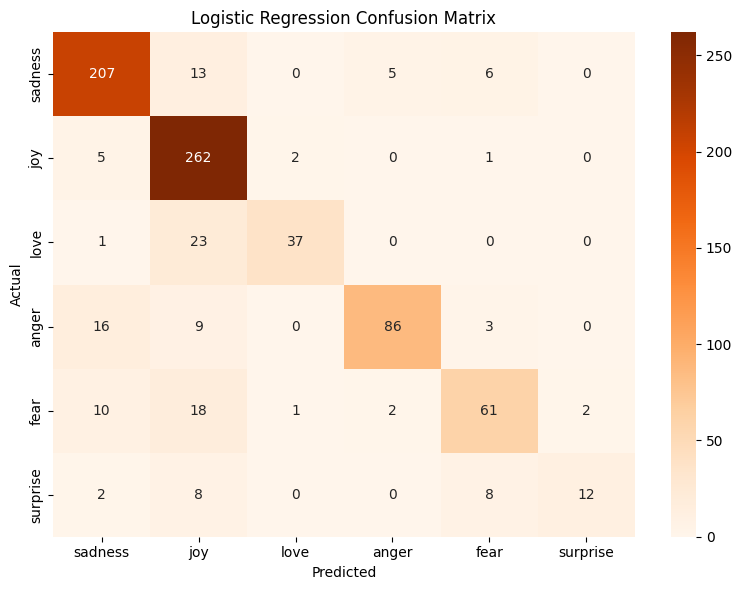

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_lr = lr_model.predict(X_test)  

target_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

print("Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=target_names))

# logistic regression confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.tight_layout()
plt.show()



### BiLSTM

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
BiLSTM Classification Report:
              precision    recall  f1-score   support

     sadness       0.90      0.94      0.92       231
         joy       0.90      0.93      0.92       270
        love       0.87      0.67      0.76        61
       anger       0.89      0.85      0.87       114
        fear       0.81      0.88      0.84        94
    surprise       0.82      0.60      0.69        30

    accuracy                           0.88       800
   macro avg       0.86      0.81      0.83       800
weighted avg       0.88      0.88      0.88       800



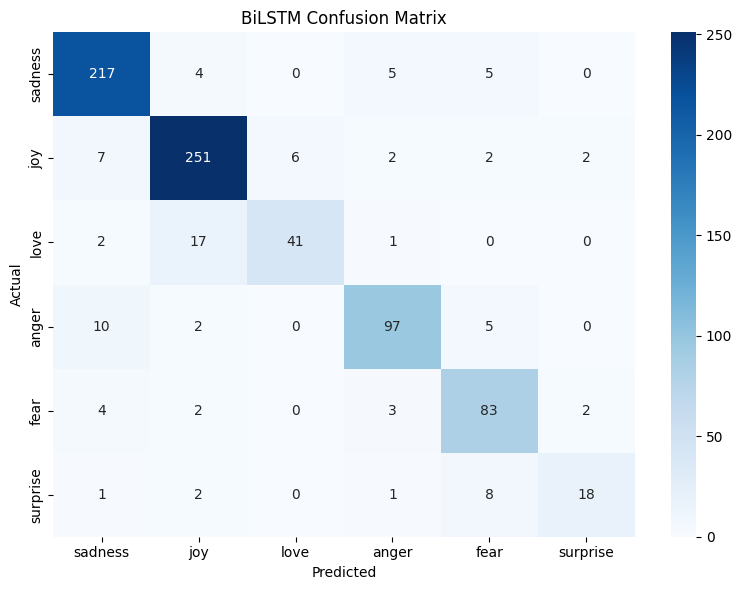

In [30]:
y_pred_prob = bilstm_model.predict(X_test_seq)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

print("BiLSTM Classification Report:")
print(classification_report(y_test_enc, y_pred_labels, target_names=target_names))

# bilstm confusion matrix
cm = confusion_matrix(y_test_enc, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("BiLSTM Confusion Matrix")
plt.tight_layout()
plt.show()


### BERT

BERT Classification Report:
              precision    recall  f1-score   support

     sadness       0.95      0.94      0.95       231
         joy       0.94      0.91      0.93       270
        love       0.74      0.75      0.75        61
       anger       0.91      0.93      0.92       114
        fear       0.84      0.94      0.88        94
    surprise       0.82      0.77      0.79        30

    accuracy                           0.91       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.91      0.91      0.91       800



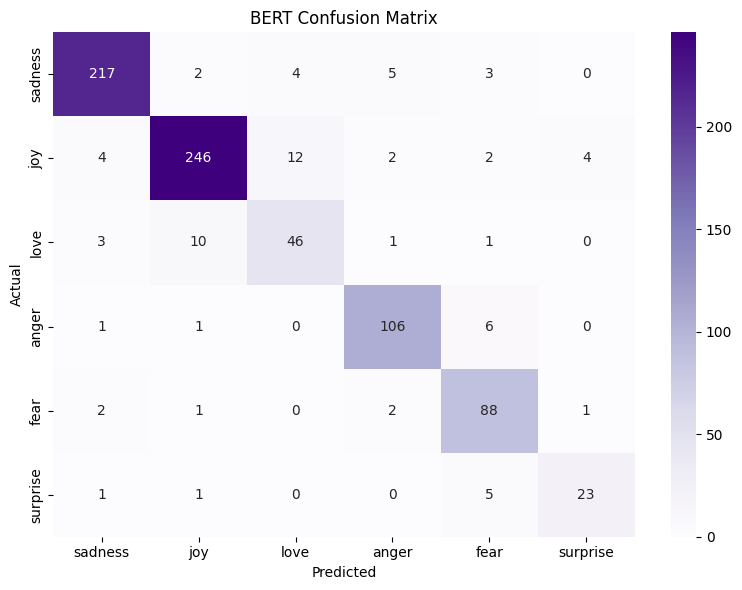

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

preds = trainer.predict(test_dataset)
y_pred_bert = np.argmax(preds.predictions, axis=1)
y_true_bert = preds.label_ids

print("BERT Classification Report:")
print(classification_report(y_true_bert, y_pred_bert, target_names=target_names))

# bert confusion matrix
cm = confusion_matrix(y_true_bert, y_pred_bert)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("BERT Confusion Matrix")
plt.tight_layout()
plt.show()


### Other Visualizations

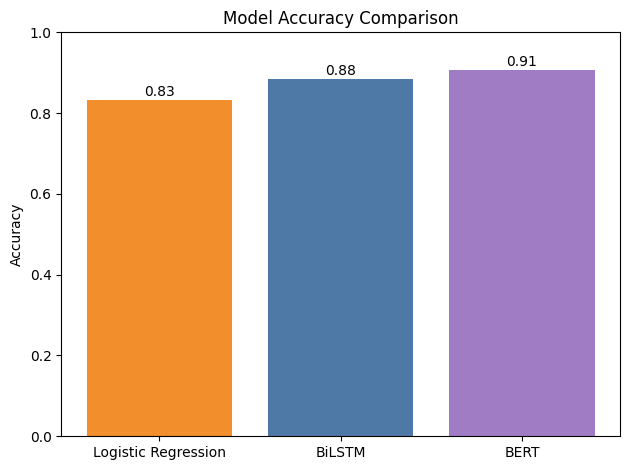

In [32]:
from sklearn.metrics import accuracy_score

accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_bilstm = accuracy_score(y_test_enc, y_pred_labels)
accuracy_bert = accuracy_score(y_true_bert, y_pred_bert)

accuracies = {
    'Logistic Regression': accuracy_lr,
    'BiLSTM': accuracy_bilstm,
    'BERT': accuracy_bert
}

# comparison of accuracy
colors = ['#F28E2B', '#4E79A7', '#A07CC5']
x_labels = list(accuracies.keys())
y_values = list(accuracies.values())

plt.bar(x_labels, y_values, color=colors)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

for i, v in enumerate(y_values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_2244\3217825250.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


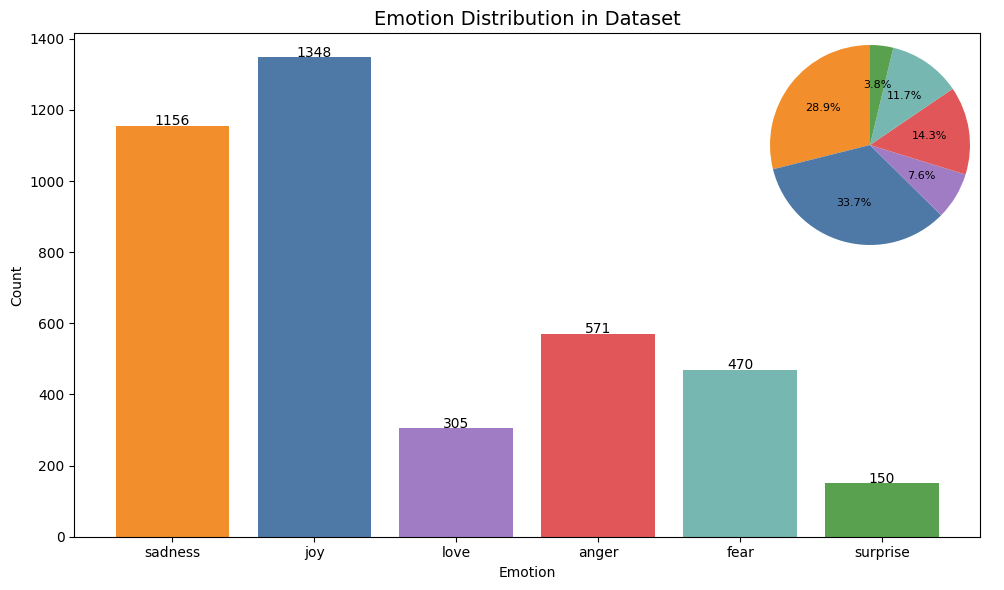

In [33]:
import matplotlib.pyplot as plt

# Emotion counts and labels
counts = data['label'].value_counts().sort_index()
labels = target_names  # ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']

# Darker, professional color palette
colors = ['#F28E2B', '#4E79A7', '#A07CC5', '#E15759', '#76B7B2', '#59A14F']

fig, ax = plt.subplots(figsize=(10, 6))

# --- Bar Chart ---
bars = ax.bar(range(6), counts, color=colors)
ax.set_title("Emotion Distribution in Dataset", fontsize=14)
ax.set_xlabel("Emotion")
ax.set_ylabel("Count")
ax.set_xticks(range(6))
ax.set_xticklabels(labels, rotation=0)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 2, int(yval),
            ha='center', fontsize=10)

# --- Inset Pie Chart (regular style) ---
inset_ax = fig.add_axes([0.75, 0.45, 0.25, 0.6])  # [left, bottom, width, height]
inset_ax.pie(
    counts, autopct='%1.1f%%',
    startangle=90, colors=colors, textprops={'fontsize': 8}
)

plt.tight_layout()
plt.show()


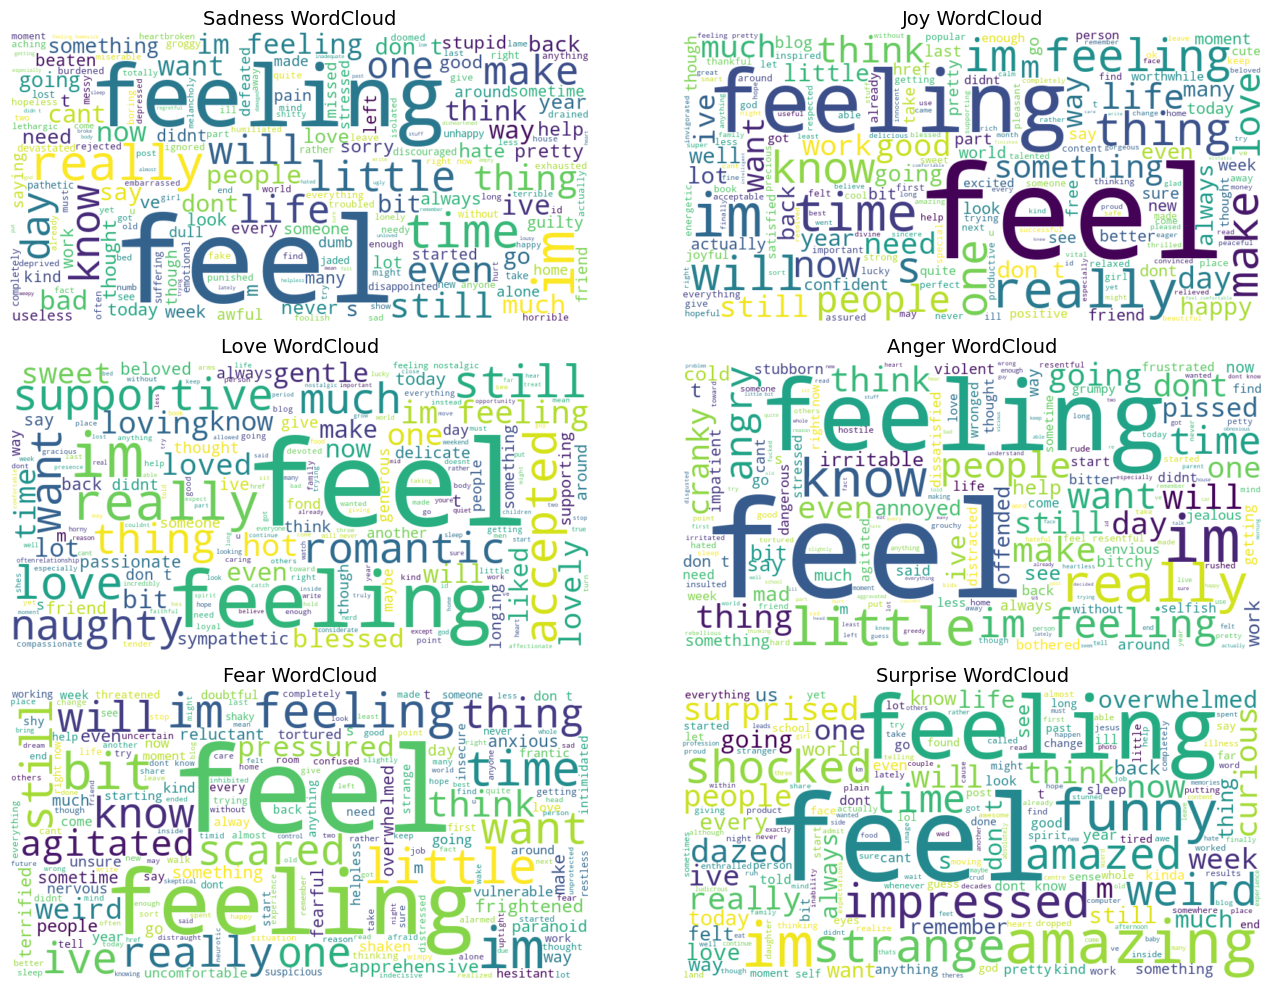

In [34]:
from wordcloud import WordCloud

label_map = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten() 

for i, label_id in enumerate(sorted(data['label'].unique())):
    emotion_name = label_map[label_id]
    text = ' '.join(data[data['label'] == label_id]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"{emotion_name} WordCloud", fontsize=14)


for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


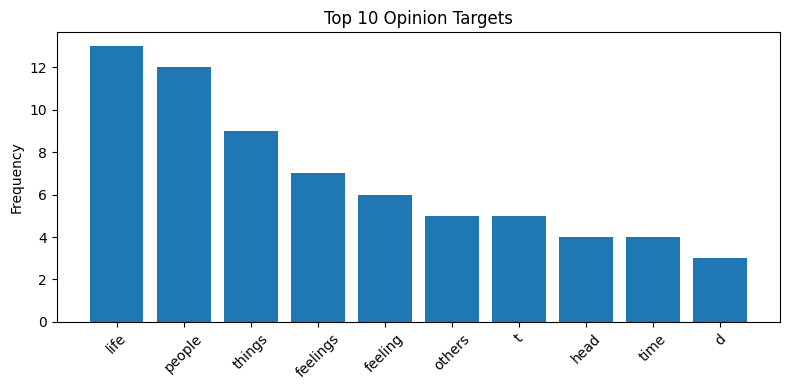

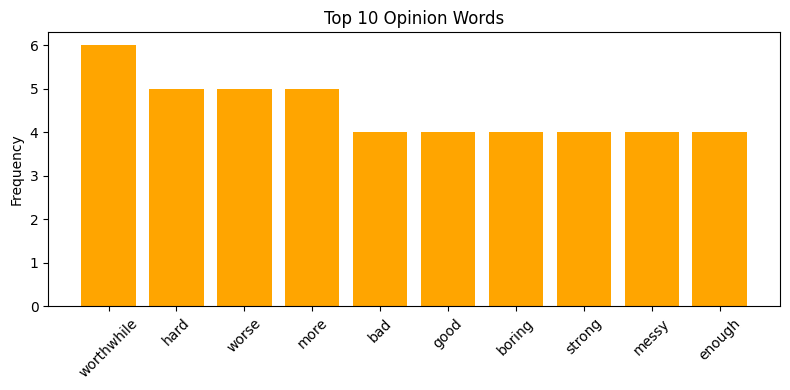

In [35]:
# top 10 opinion targets
plt.figure(figsize=(8, 4))
plt.bar(*zip(*target_counter.most_common(10)))
plt.title("Top 10 Opinion Targets")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# top 10 opinion words
plt.figure(figsize=(8, 4))
plt.bar(*zip(*opinion_counter.most_common(10)), color='orange')
plt.title("Top 10 Opinion Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()